# **import**

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  


# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  

# **데이터 전처리**

In [16]:
# 데이터 변환 (Data Augmentation 포함)
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
    ], p=0.5),
    transforms.ToTensor(),
])

# 데이터셋 로드 및 분할
dataset = datasets.ImageFolder('image/', transform=transform)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"훈련 데이터셋: {len(train_loader)} 배치")
print(f"검증 데이터셋: {len(val_loader)} 배치")


훈련 데이터셋: 63 배치
검증 데이터셋: 7 배치


# **모델 학습**

In [23]:
# 모델 설정
base_model = models.resnet50(pretrained=True)

# ResNet50의 마지막 10개 레이어만 학습 가능하게 설정 (나머지 동결)
for name, param in list(base_model.named_parameters())[:-10]:
    param.requires_grad = False

# 새로운 Fully Connected Layer 추가
num_features = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCELoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, min_lr=1e-5, verbose=True)

# 모델 학습 및 검증 함수
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_loss = float('inf')  # 최소 validation loss를 저장하기 위해 초기값을 무한대로 설정

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # tqdm을 사용하여 학습 진행 상황 표시
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for images, labels in train_bar:
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # tqdm 설명 업데이트
            train_bar.set_postfix({
                'loss': running_loss / len(train_loader),
                'acc': correct / total
            })

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.float().to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct / total

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Learning rate scheduler step
        scheduler.step(val_acc)

        # Checkpoint: validation loss가 개선되었을 때 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'model.pth')

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

# 모델 학습 및 기록된 손실과 정확도 반환
train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_and_evaluate(
    base_model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=10
)


Epoch 1/10: 100%|██████████| 63/63 [11:15<00:00, 10.73s/batch, loss=0.047, acc=0.982] 


Epoch [1/10], Train Loss: 0.0470, Train Accuracy: 0.9821, Val Loss: 0.0031, Val Accuracy: 1.0000


Epoch 2/10: 100%|██████████| 63/63 [11:15<00:00, 10.73s/batch, loss=0.00357, acc=1] 


Epoch [2/10], Train Loss: 0.0036, Train Accuracy: 1.0000, Val Loss: 0.0023, Val Accuracy: 1.0000


Epoch 3/10: 100%|██████████| 63/63 [11:09<00:00, 10.63s/batch, loss=0.00208, acc=1] 


Epoch [3/10], Train Loss: 0.0021, Train Accuracy: 1.0000, Val Loss: 0.0081, Val Accuracy: 0.9955


Epoch 4/10: 100%|██████████| 63/63 [11:01<00:00, 10.50s/batch, loss=0.00177, acc=1] 


Epoch [4/10], Train Loss: 0.0018, Train Accuracy: 1.0000, Val Loss: 0.0016, Val Accuracy: 1.0000


Epoch 5/10: 100%|██████████| 63/63 [11:02<00:00, 10.52s/batch, loss=0.00042, acc=1] 


Epoch [5/10], Train Loss: 0.0004, Train Accuracy: 1.0000, Val Loss: 0.0008, Val Accuracy: 1.0000


Epoch 6/10: 100%|██████████| 63/63 [11:10<00:00, 10.65s/batch, loss=0.000697, acc=1]


Epoch [6/10], Train Loss: 0.0007, Train Accuracy: 1.0000, Val Loss: 0.0005, Val Accuracy: 1.0000


Epoch 7/10: 100%|██████████| 63/63 [11:49<00:00, 11.26s/batch, loss=0.000225, acc=1]


Epoch [7/10], Train Loss: 0.0002, Train Accuracy: 1.0000, Val Loss: 0.0003, Val Accuracy: 1.0000


Epoch 8/10: 100%|██████████| 63/63 [11:50<00:00, 11.28s/batch, loss=0.000175, acc=1]


Epoch [8/10], Train Loss: 0.0002, Train Accuracy: 1.0000, Val Loss: 0.0005, Val Accuracy: 1.0000


Epoch 9/10: 100%|██████████| 63/63 [11:48<00:00, 11.24s/batch, loss=0.00017, acc=1] 


Epoch [9/10], Train Loss: 0.0002, Train Accuracy: 1.0000, Val Loss: 0.0004, Val Accuracy: 1.0000


Epoch 10/10: 100%|██████████| 63/63 [11:51<00:00, 11.29s/batch, loss=0.000179, acc=1]


Epoch [10/10], Train Loss: 0.0002, Train Accuracy: 1.0000, Val Loss: 0.0005, Val Accuracy: 1.0000


# **시각화**

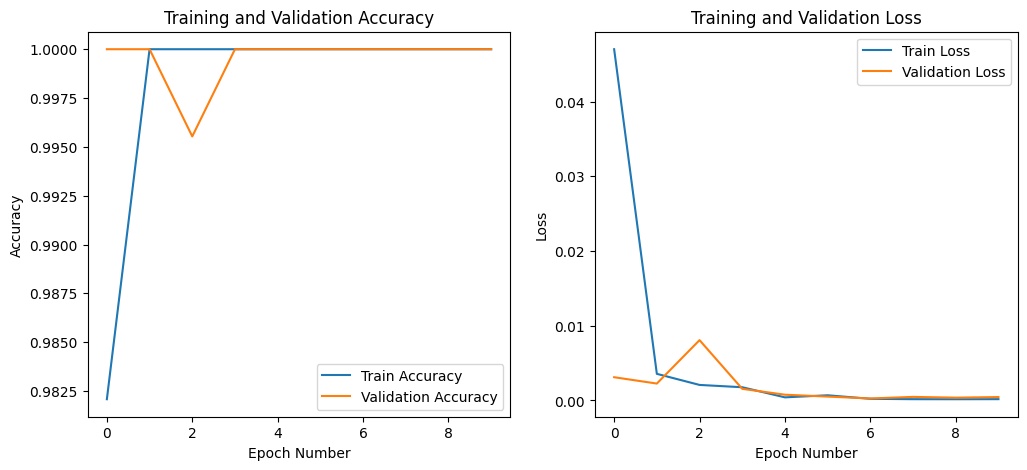

In [24]:
# 학습 결과 시각화
def visualize_training(train_loss, val_loss, train_acc, val_acc):
    epochs_range = range(len(train_loss))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

visualize_training(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

# **테스트**

C:\Users\user\AppData\Local\Temp\ipykernel_16952\2394997971.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


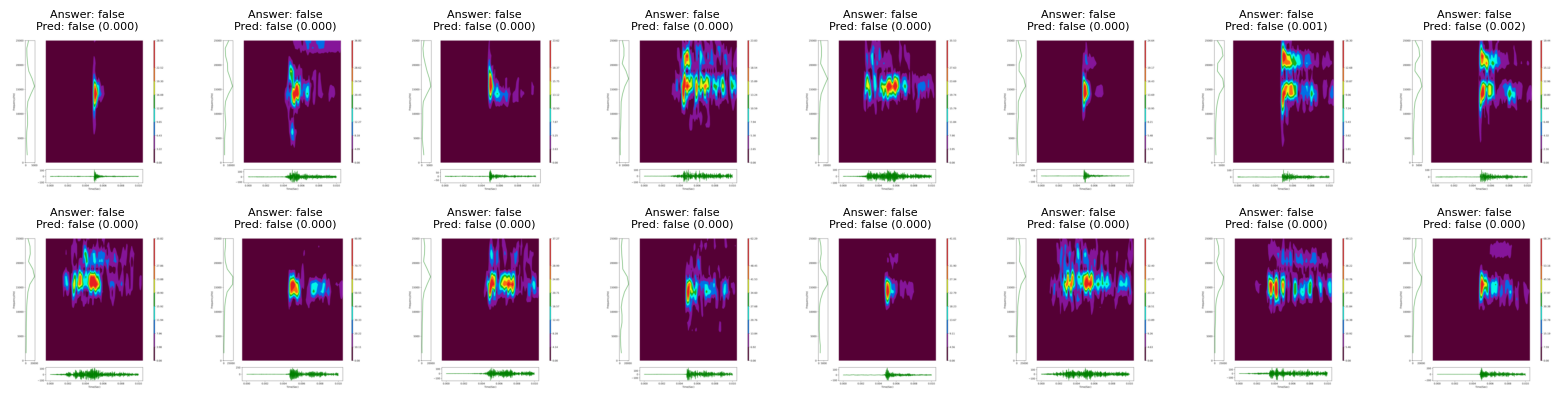

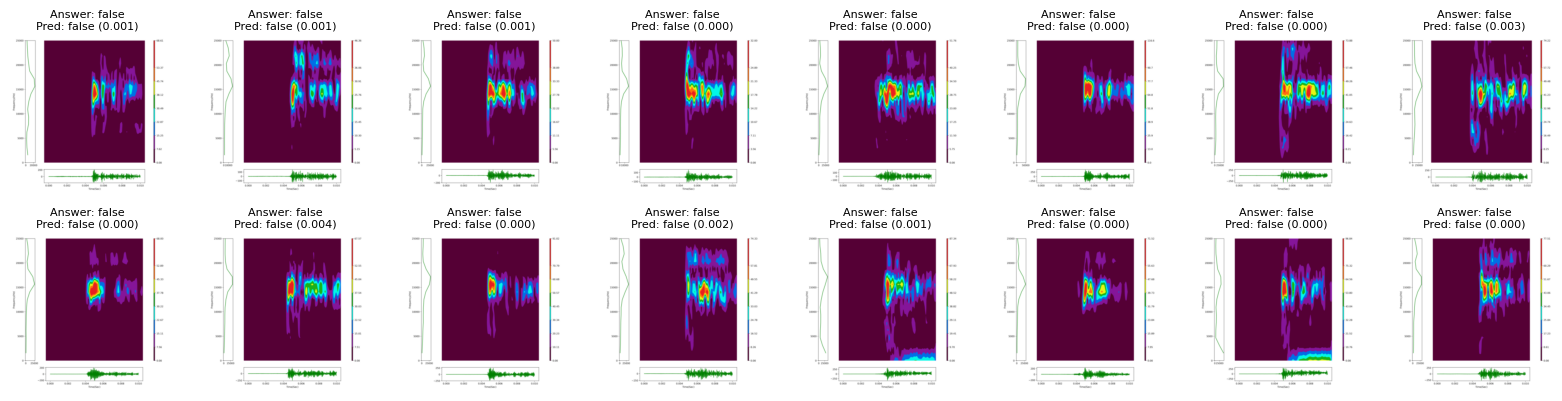

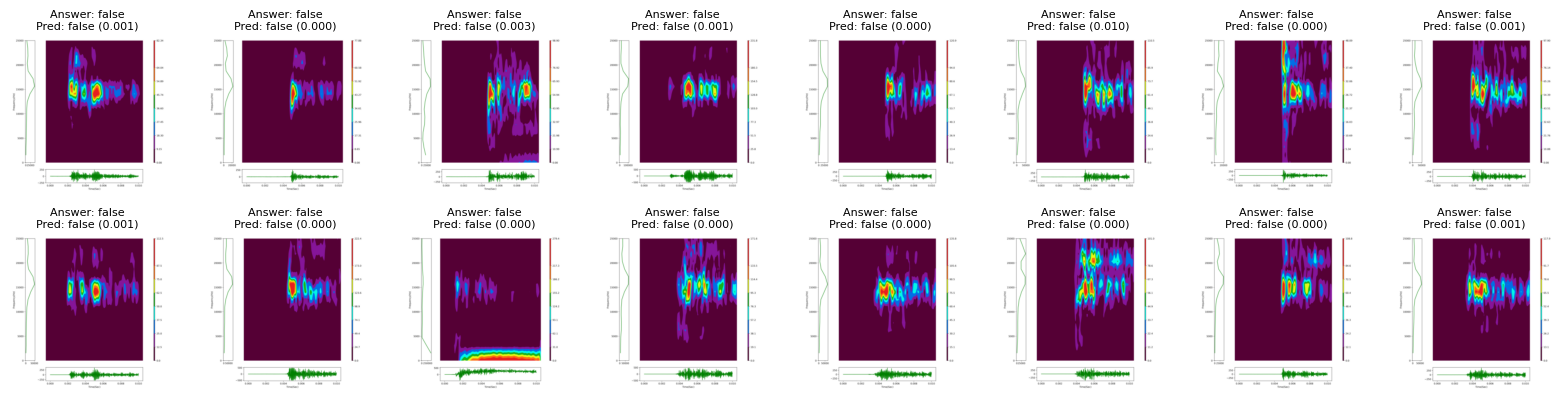

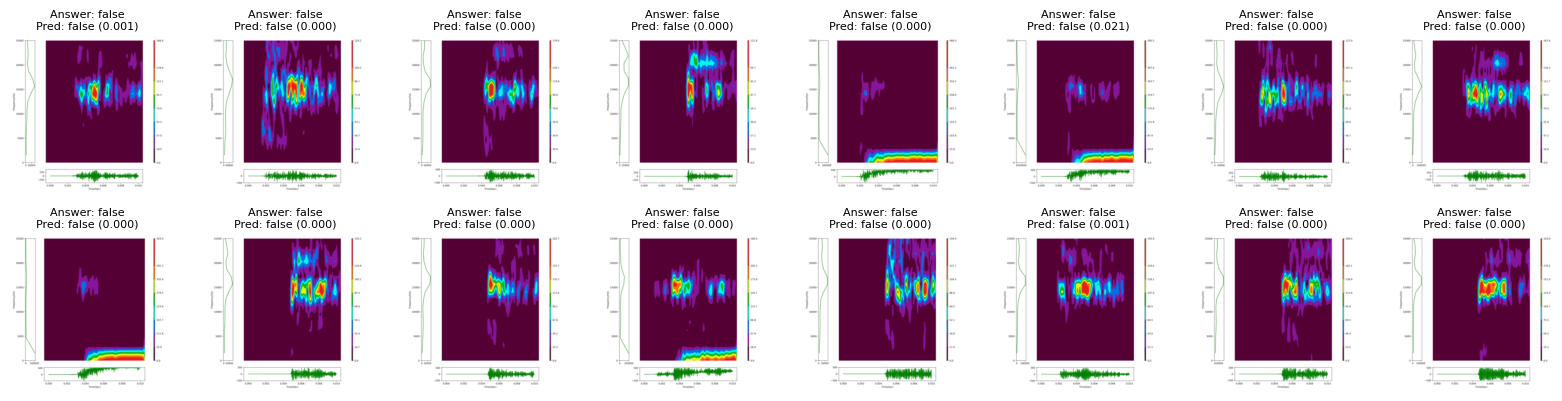

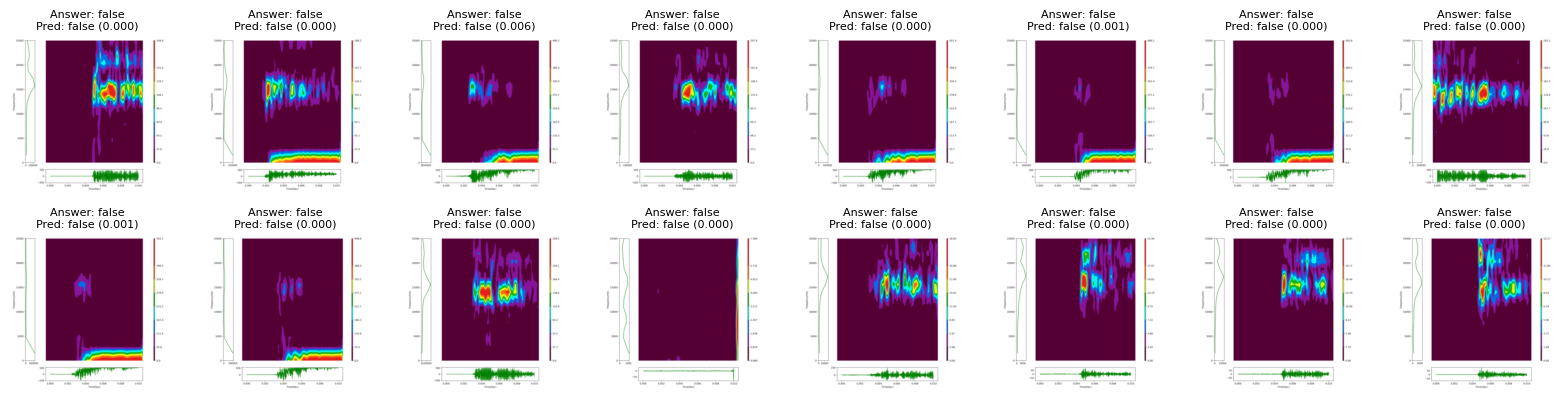

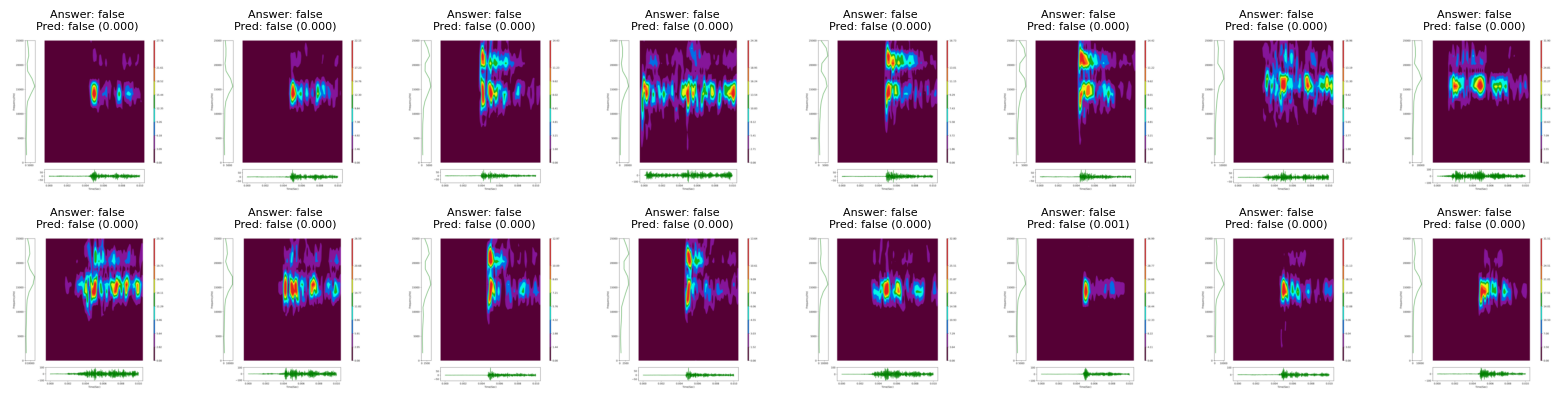

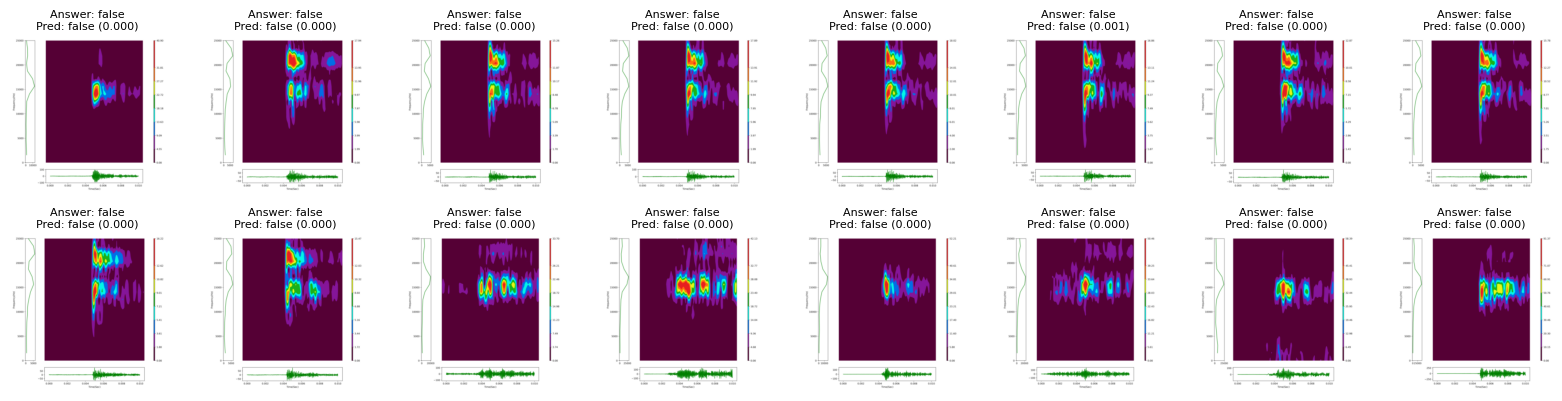

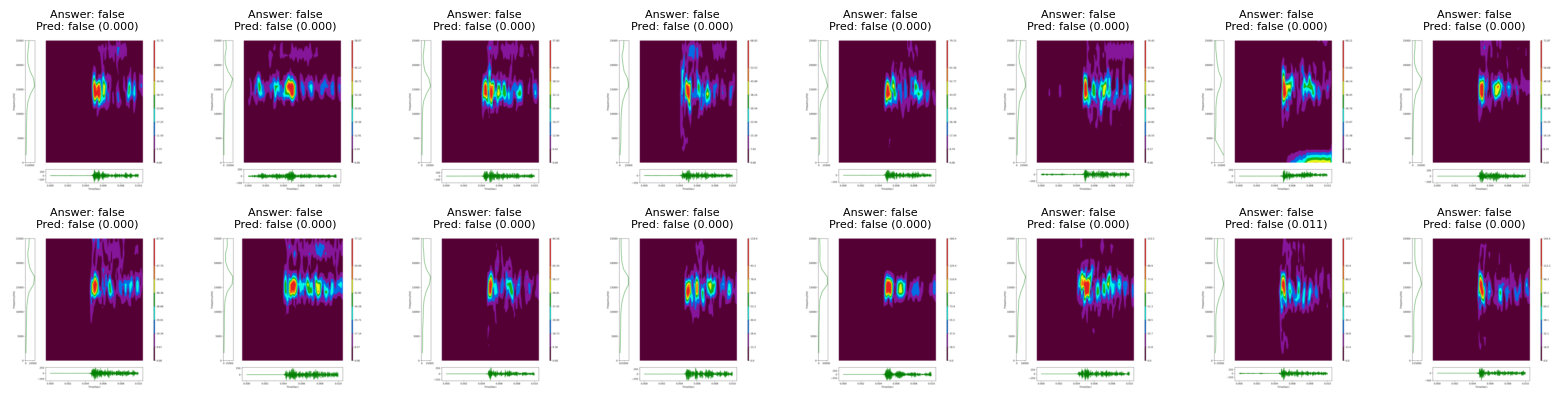

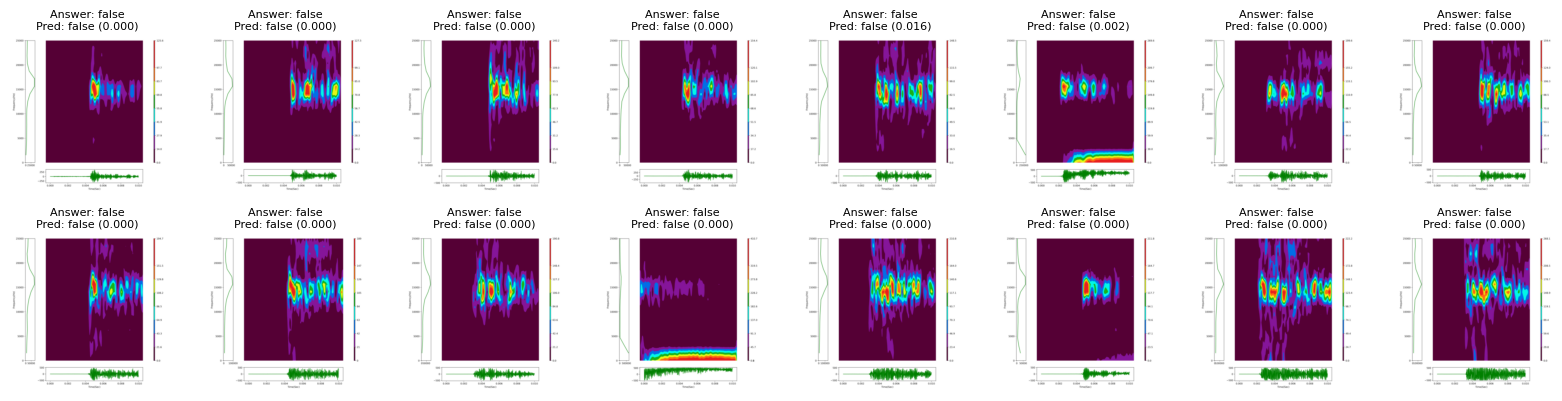

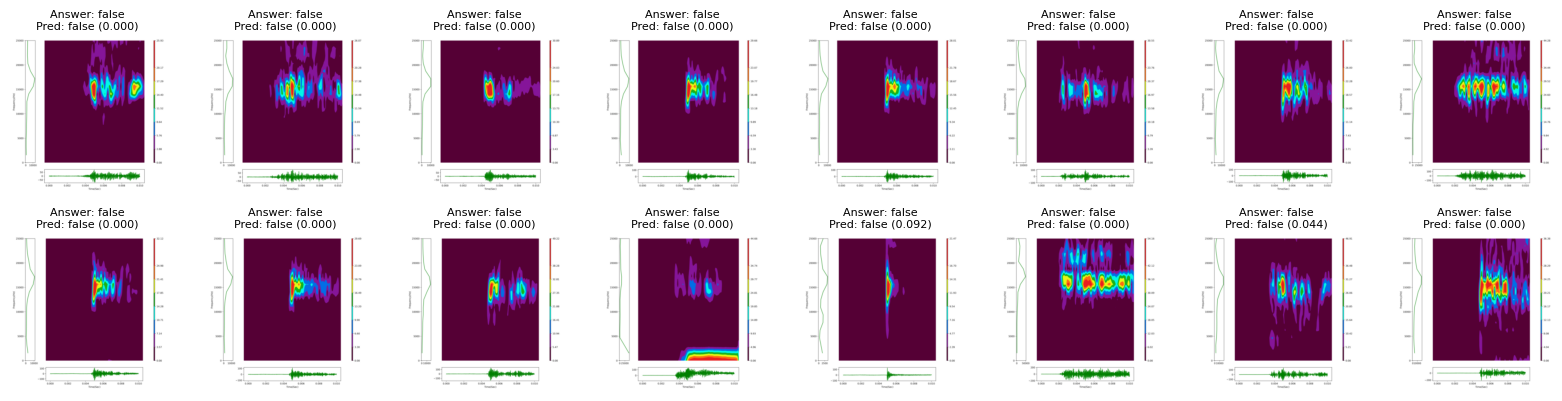

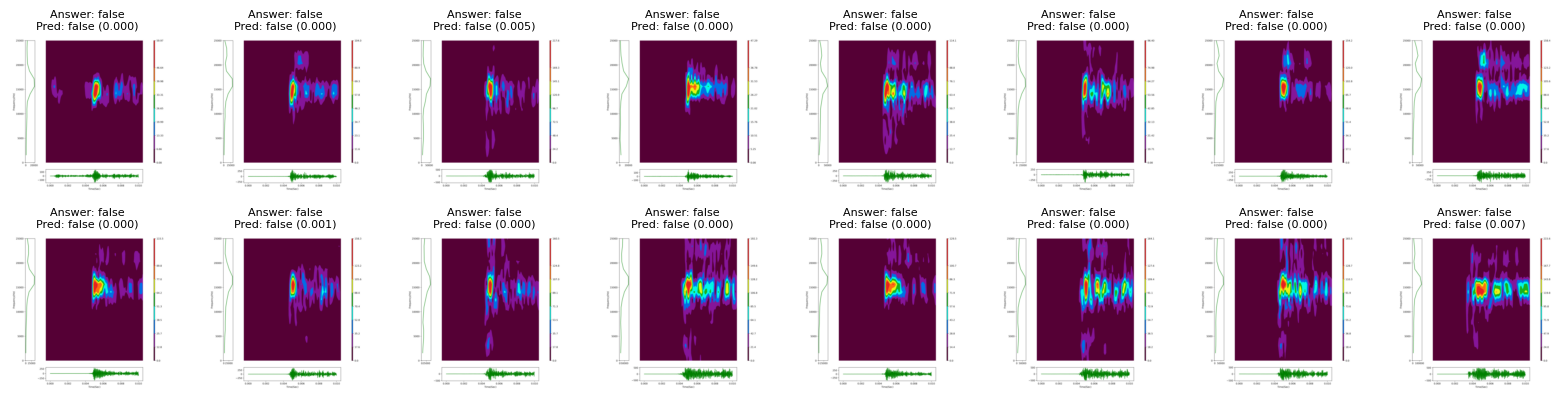

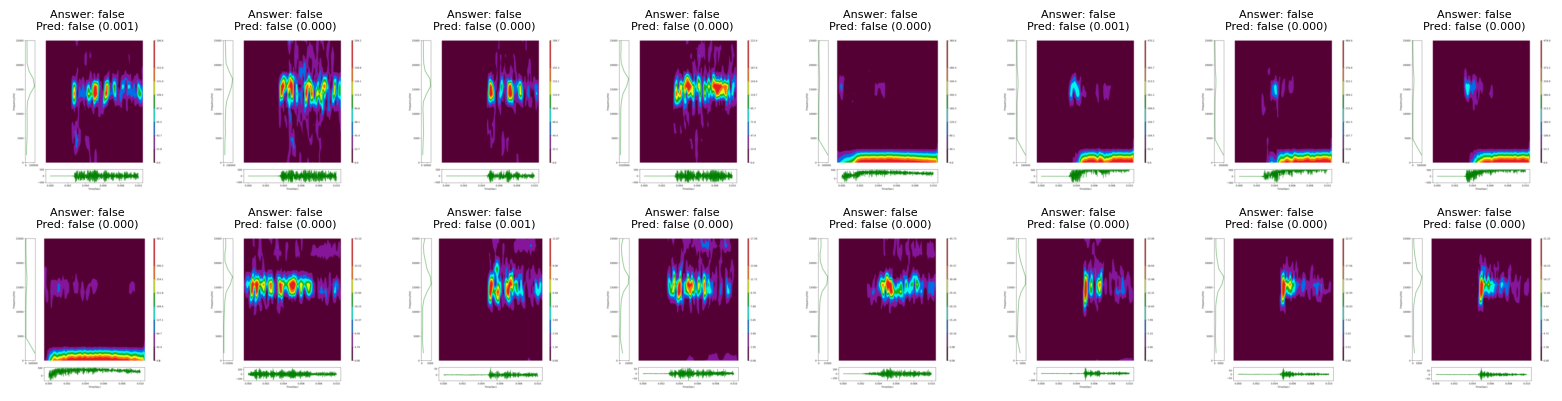

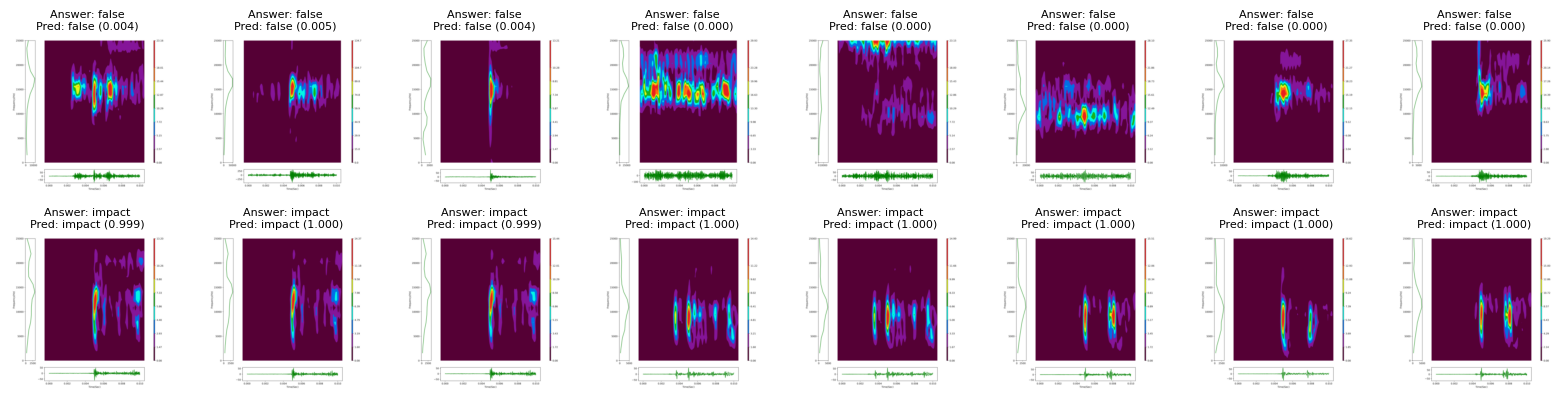

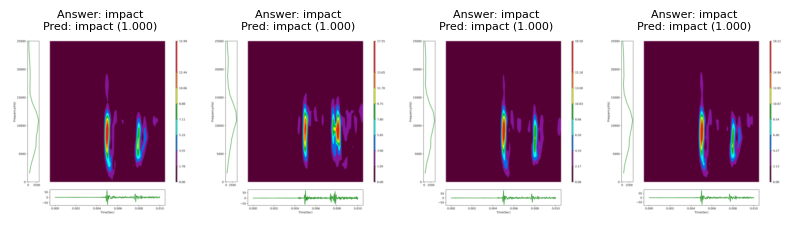

정확도: 100.00%


In [21]:

# 테스트 데이터 변환 및 데이터 로드 (정규화 없이)
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),  # 정규화 없이 Tensor로 변환
])

test_dataset = datasets.ImageFolder('test_image/', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 모델 구조 정의 (원래 학습에 사용한 모델 구조와 동일해야 함)
model = models.resnet50(pretrained=False)  # 기본 모델 구조
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)

# 저장된 가중치를 모델에 로드
model.load_state_dict(torch.load('model.pth'))

model = model.to(device)
model.eval()  # 모델을 평가 모드로 설정

# 클래스 이름 리스트
class_names = ['false', 'impact']  # 실제 클래스 이름으로 수정

all_predictions = []
all_labels = []

# 테스트 데이터셋에서 배치 가져오기
with torch.no_grad():  # 역전파 비활성화 (평가시 필요 없음)
    for images, labels in test_loader:  # 모든 배치를 순회
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        #print(f'outputs = {outputs}')
        #predictions = torch.round(torch.sigmoid(outputs)).cpu().numpy()  # 예측값 계산

        #print(f'predictions = {predictions}')
        #print(predictions.shape)
        plt.figure(figsize=(16, 16))
        for i in range(len(images)):
            ax = plt.subplot(8, 8, i + 1)  # 8x8 그리드에 이미지 배치
            plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))  # 이미지 출력

            true_label = class_names[labels[i].item()]  # 실제 라벨
            pred = outputs[i].item()
            #print(f'pred = {pred}')
            rounded = round(pred)
            #print(f'rounded = {rounded}')
            predicted_label = class_names[rounded]  # 예측된 라벨
            #print(f'predicted_label = {predicted_label}')

            all_predictions.append(rounded)
            all_labels.append(labels[i].item())

            if true_label == predicted_label:
                plt.title(f"Answer: {true_label}\nPred: {predicted_label} ({pred:.3f})", fontsize=8)  # 타이틀 출력
            else:
                plt.title(f"Answer: {true_label}\nPred: {predicted_label} ({pred:.3f})\nDiff", fontsize=8)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

# 정확도 계산
accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
print(f'정확도: {accuracy * 100:.2f}%')
